# Xác định vị trí người dùng dựa trên WiFi Fingerprinting

Notebook này xây dựng mô hình học máy để dự đoán vị trí của người dùng dựa trên cường độ tín hiệu WiFi (RSSI) từ các access point khác nhau. Kỹ thuật này được gọi là WiFi fingerprinting.

## Mục tiêu:
- Xây dựng mô hình dự đoán tọa độ vị trí (LONGITUDE, LATITUDE) từ dữ liệu RSSI
- Đánh giá hiệu suất mô hình trên tập validation
- Thực hiện dự đoán vị trí cho mẫu dữ liệu mới

## 1. Import Thư Viện Cần Thiết

Import các thư viện cần thiết để xử lý dữ liệu, xây dựng và đánh giá mô hình.

In [2]:
# Cài đặt các thư viện cần thiết
%pip install scikit-learn matplotlib seaborn pandas numpy

# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

# Thiết lập hiển thị
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Đã import thành công tất cả thư viện!")
print("📦 Các thư viện đã sẵn sàng cho việc xây dựng mô hình WiFi fingerprinting")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn]━━━━━ 2/3 [scikit-learn]
Note: you may need to restart the kernel to use updated packages.
✅ Đã import thành công tất cả thư viện!
📦 Các thư viện đã sẵn sàng cho việc xây dựng mô hình WiFi fingerprinting


## 2. Nạp Dữ Liệu Huấn Luyện và Kiểm Tra

Đọc dữ liệu từ hai file CSV chứa thông tin training và validation data.

In [3]:
# Nạp dữ liệu từ file CSV
train_data = pd.read_csv('B0_training_data_m95.csv')
validation_data = pd.read_csv('B0_validation_data_m95.csv')

print(f"Dữ liệu huấn luyện: {train_data.shape}")
print(f"Dữ liệu kiểm tra: {validation_data.shape}")
print("\nCột dữ liệu:")
print(train_data.columns.tolist())

print("\n5 dòng đầu của dữ liệu huấn luyện:")
print(train_data.head())

Dữ liệu huấn luyện: (5249, 21)
Dữ liệu kiểm tra: (536, 21)

Cột dữ liệu:
['FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP', 'LONGITUDE', 'LATITUDE', 'AP13', 'AP14', 'AP35', 'AP36', 'AP41', 'AP42', 'AP51', 'AP52', 'AP155', 'AP156', 'AP161', 'AP162']

5 dòng đầu của dữ liệu huấn luyện:
   FLOOR  BUILDINGID  SPACEID  RELATIVEPOSITION  USERID  PHONEID  \
0    0.0         0.0    122.0               2.0    11.0     13.0   
1    0.0         0.0    102.0               2.0    11.0     13.0   
2    0.0         0.0    110.0               2.0    11.0     13.0   
3    0.0         0.0    111.0               2.0    11.0     13.0   
4    0.0         0.0    107.0               2.0    11.0     13.0   

      TIMESTAMP  LONGITUDE      LATITUDE   AP13   AP14   AP35   AP36   AP41  \
0  1.369910e+09 -7632.1436  4.864982e+06 -105.0 -105.0 -105.0 -105.0 -105.0   
1  1.369909e+09 -7637.2570  4.864950e+06 -105.0 -105.0 -105.0 -105.0 -105.0   
2  1.369909e+09 -7628.1345  4.8

## 3. Tiền Xử Lý Dữ Liệu

Kiểm tra và xử lý dữ liệu RSSI, giá trị thiếu và chuẩn hóa dữ liệu nếu cần.

In [6]:
# Kiểm tra thông tin chi tiết về dữ liệu
print("=== THÔNG TIN DỮ LIỆU HUẤN LUYỆN ===")
print(f"Kích thước: {train_data.shape}")
print(f"Số giá trị thiếu: {train_data.isnull().sum().sum()}")
print("\nCác cột trong dữ liệu:")
print(train_data.columns.tolist()[:10], "...") # Hiển thị 10 cột đầu

print("\n=== THÔNG TIN DỮ LIỆU VALIDATION ===")
print(f"Kích thước: {validation_data.shape}")
print(f"Số giá trị thiếu: {validation_data.isnull().sum().sum()}")

# Tách các cột đặc trưng RSSI và nhãn vị trí
rssi_columns = [col for col in train_data.columns if col not in ['LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP']]
target_columns = ['LONGITUDE', 'LATITUDE']

print(f"\nSố lượng access points (cột RSSI): {len(rssi_columns)}")
print(f"Cột nhãn: {target_columns}")

# Kiểm tra phạm vi giá trị RSSI
print(f"\nPhạm vi giá trị RSSI:")
print(f"Min: {train_data[rssi_columns].min().min()}")
print(f"Max: {train_data[rssi_columns].max().max()}")

# Kiểm tra phân bố giá trị RSSI
rssi_values = train_data[rssi_columns].values.flatten()
unique_rssi = np.unique(rssi_values)
print(f"\nSố lượng giá trị RSSI duy nhất: {len(unique_rssi)}")

# Tìm giá trị RSSI phổ biến nhất (mode)
from scipy import stats
mode_result = stats.mode(rssi_values, keepdims=True)
print(f"Giá trị RSSI phổ biến nhất: {mode_result.mode[0]} (xuất hiện {mode_result.count[0]} lần)")

=== THÔNG TIN DỮ LIỆU HUẤN LUYỆN ===
Kích thước: (5249, 21)
Số giá trị thiếu: 0

Các cột trong dữ liệu:
['FLOOR', 'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP', 'LONGITUDE', 'LATITUDE', 'AP13'] ...

=== THÔNG TIN DỮ LIỆU VALIDATION ===
Kích thước: (536, 21)
Số giá trị thiếu: 0

Số lượng access points (cột RSSI): 12
Cột nhãn: ['LONGITUDE', 'LATITUDE']

Phạm vi giá trị RSSI:
Min: -105.0
Max: -31.0

Số lượng giá trị RSSI duy nhất: 71
Giá trị RSSI phổ biến nhất: -105.0 (xuất hiện 38985 lần)


In [7]:
# Xử lý giá trị RSSI = 100 (không nhận được tín hiệu)
# Trong WiFi fingerprinting, RSSI = 100 thường biểu thị không có tín hiệu
print("Số lượng giá trị RSSI = 100 (không có tín hiệu):")
print(f"Train data: {(train_data[rssi_columns] == 100).sum().sum()}")
print(f"Validation data: {(validation_data[rssi_columns] == 100).sum().sum()}")

# Thay thế giá trị 100 bằng -100 (giá trị RSSI rất thấp)
train_data_processed = train_data.copy()
val_data_processed = validation_data.copy()

for col in rssi_columns:
    train_data_processed[col] = train_data_processed[col].replace(100, -100)
    val_data_processed[col] = val_data_processed[col].replace(100, -100)

print("\\nSau khi xử lý:")
print(f"Phạm vi RSSI train: {train_data_processed[rssi_columns].min().min()} đến {train_data_processed[rssi_columns].max().max()}")
print(f"Phạm vi RSSI validation: {val_data_processed[rssi_columns].min().min()} đến {val_data_processed[rssi_columns].max().max()}")

# Kiểm tra phân bố vị trí
print(f"\nPhạm vi tọa độ trong tập huấn luyện:")
print(f"LONGITUDE: {train_data_processed['LONGITUDE'].min():.2f} đến {train_data_processed['LONGITUDE'].max():.2f}")
print(f"LATITUDE: {train_data_processed['LATITUDE'].min():.2f} đến {train_data_processed['LATITUDE'].max():.2f}")

print(f"\nPhạm vi tọa độ trong tập validation:")
print(f"LONGITUDE: {val_data_processed['LONGITUDE'].min():.2f} đến {val_data_processed['LONGITUDE'].max():.2f}")
print(f"LATITUDE: {val_data_processed['LATITUDE'].min():.2f} đến {val_data_processed['LATITUDE'].max():.2f}")

Số lượng giá trị RSSI = 100 (không có tín hiệu):
Train data: 0
Validation data: 0
\nSau khi xử lý:
Phạm vi RSSI train: -105.0 đến -31.0
Phạm vi RSSI validation: -105.0 đến -40.0

Phạm vi tọa độ trong tập huấn luyện:
LONGITUDE: -7691.34 đến -7587.04
LATITUDE: 4864897.53 đến 4865016.69

Phạm vi tọa độ trong tập validation:
LONGITUDE: -7695.94 đến -7585.39
LATITUDE: 4864894.80 đến 4865017.37


## 4. Khám Phá Dữ Liệu (Exploratory Data Analysis)

Trong bước này, chúng ta sẽ:
- Phân tích phân bố của các giá trị RSSI
- Trực quan hóa vị trí trong không gian 2D
- Tìm hiểu mối quan hệ giữa tín hiệu WiFi và vị trí
- Phân tích mật độ dữ liệu theo không gian

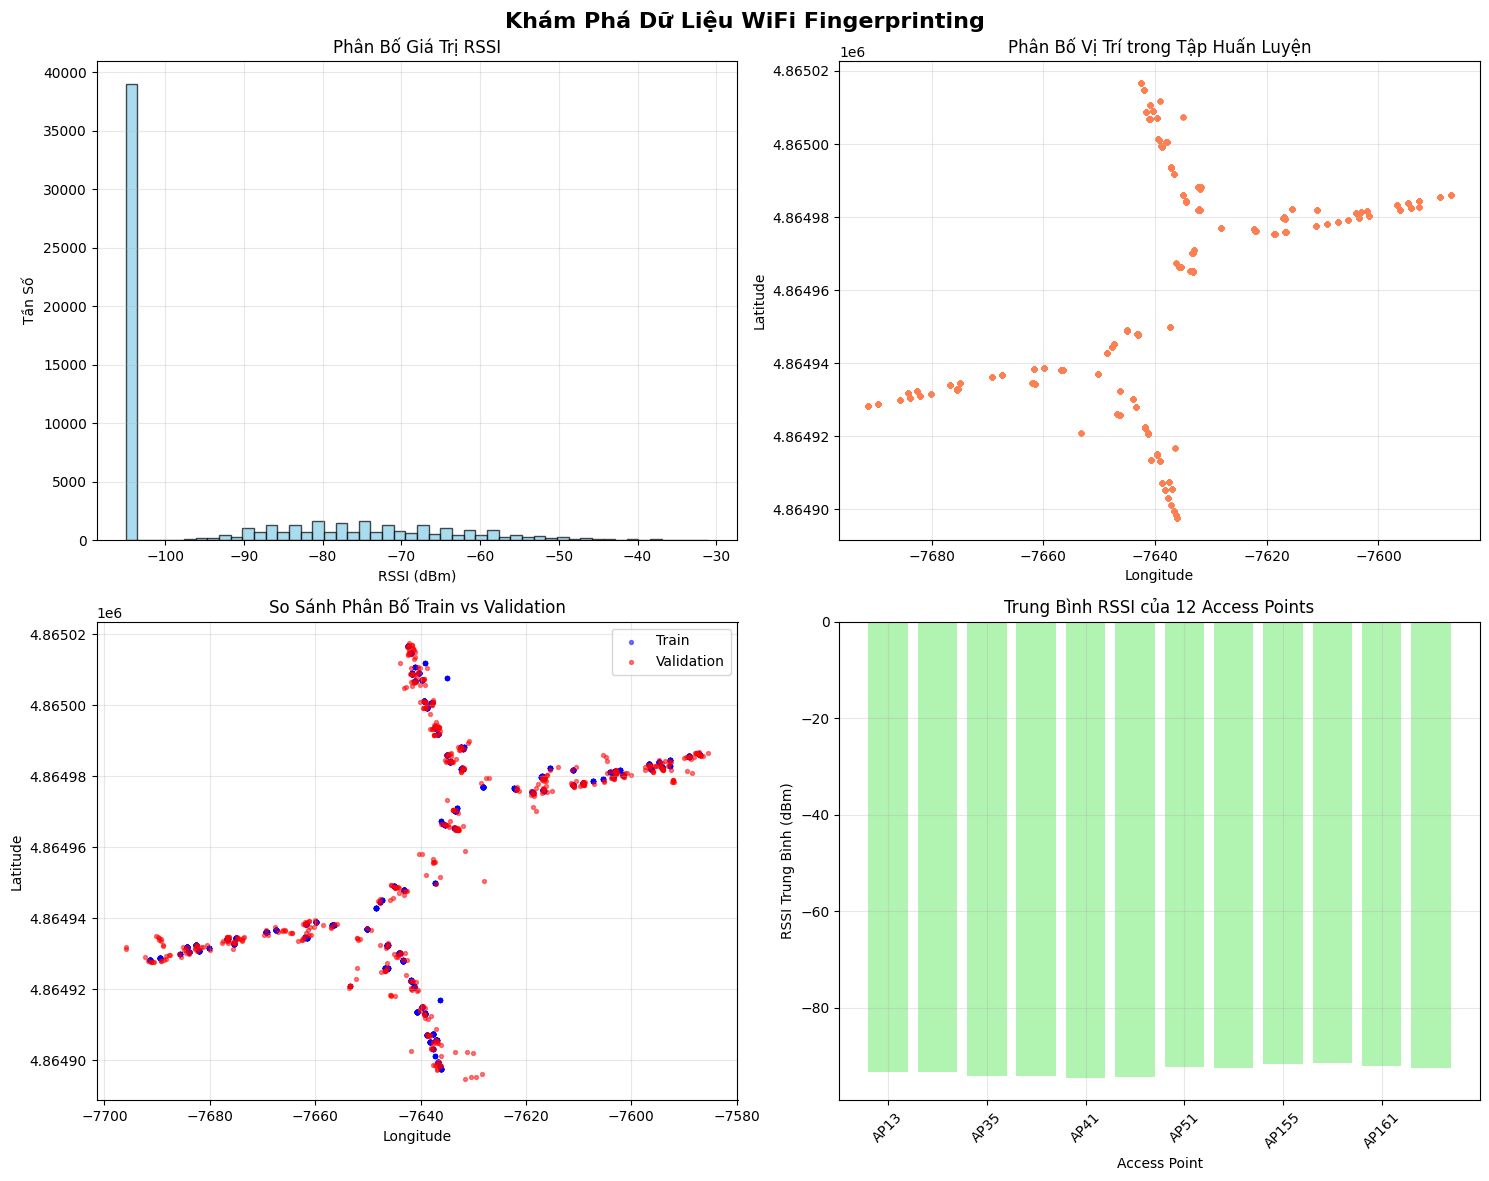

=== THỐNG KÊ MÔ TẢ ===
Số điểm dữ liệu train: 5249
Số điểm dữ liệu validation: 536
Số access point: 12

Thống kê RSSI:
Trung bình: -92.99 dBm
Độ lệch chuẩn: 16.96 dBm
Min: -105.00 dBm
Max: -31.00 dBm


In [9]:
# Thiết lập style cho các biểu đồ
plt.style.use('default')
sns.set_palette("husl")

# Tạo figure với nhiều subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Khám Phá Dữ Liệu WiFi Fingerprinting', fontsize=16, fontweight='bold')

# 1. Phân bố giá trị RSSI
ax1 = axes[0, 0]
rssi_flat = train_data_processed[rssi_columns].values.flatten()
ax1.hist(rssi_flat, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Phân Bố Giá Trị RSSI')
ax1.set_xlabel('RSSI (dBm)')
ax1.set_ylabel('Tần Số')
ax1.grid(True, alpha=0.3)

# 2. Phân bố vị trí trong không gian 2D
ax2 = axes[0, 1]
scatter = ax2.scatter(train_data_processed['LONGITUDE'], train_data_processed['LATITUDE'], 
                     alpha=0.6, s=10, c='coral')
ax2.set_title('Phân Bố Vị Trí trong Tập Huấn Luyện')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.grid(True, alpha=0.3)

# 3. So sánh phân bố tọa độ giữa train và validation
ax3 = axes[1, 0]
ax3.scatter(train_data_processed['LONGITUDE'], train_data_processed['LATITUDE'], 
           alpha=0.5, s=8, label='Train', color='blue')
ax3.scatter(val_data_processed['LONGITUDE'], val_data_processed['LATITUDE'], 
           alpha=0.5, s=8, label='Validation', color='red')
ax3.set_title('So Sánh Phân Bố Train vs Validation')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Thống kê mô tả của RSSI theo từng access point
ax4 = axes[1, 1]
# Tính trung bình RSSI cho tất cả access point
num_aps = len(rssi_columns)
ap_means = train_data_processed[rssi_columns].mean().values
ap_names = [f'AP{i+1}' for i in range(num_aps)]
bars = ax4.bar(range(num_aps), ap_means, color='lightgreen', alpha=0.7)
ax4.set_title(f'Trung Bình RSSI của {num_aps} Access Points')
ax4.set_xlabel('Access Point')
ax4.set_ylabel('RSSI Trung Bình (dBm)')
ax4.set_xticks(range(0, num_aps, max(1, num_aps//6)))  # Hiển thị ít nhãn hơn nếu có nhiều AP
ax4.set_xticklabels([rssi_columns[i] for i in range(0, num_aps, max(1, num_aps//6))], rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In thống kê mô tả
print("=== THỐNG KÊ MÔ TẢ ===")
print(f"Số điểm dữ liệu train: {len(train_data_processed)}")
print(f"Số điểm dữ liệu validation: {len(val_data_processed)}")
print(f"Số access point: {len(rssi_columns)}")
print(f"\nThống kê RSSI:")
print(f"Trung bình: {rssi_flat.mean():.2f} dBm")
print(f"Độ lệch chuẩn: {rssi_flat.std():.2f} dBm")
print(f"Min: {rssi_flat.min():.2f} dBm")
print(f"Max: {rssi_flat.max():.2f} dBm")

## 5. Chuẩn Bị Dữ Liệu Cho Mô Hình

Trong bước này, chúng ta sẽ:
- Tách đặc trưng (features) và nhãn (targets)
- Chuẩn hóa dữ liệu đặc trưng
- Chuẩn bị dữ liệu cho việc huấn luyện mô hình

In [10]:
# Tách đặc trưng và nhãn cho tập huấn luyện
X_train = train_data_processed[rssi_columns].values
y_train = train_data_processed[target_columns].values

# Tách đặc trưng và nhãn cho tập validation
X_val = val_data_processed[rssi_columns].values
y_val = val_data_processed[target_columns].values

print("=== KÍCH THƯỚC DỮ LIỆU ===")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

# Chuẩn hóa dữ liệu đặc trưng (RSSI)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

# Chuẩn hóa nhãn (tọa độ) - tùy chọn, có thể giúp cải thiện hiệu suất
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

print("\n=== THỐNG KÊ SAU CHUẨN HÓA ===")
print(f"X_train_scaled - Mean: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")
print(f"y_train_scaled - Mean: {y_train_scaled.mean():.4f}, Std: {y_train_scaled.std():.4f}")

# Hiển thị ví dụ về dữ liệu trước và sau chuẩn hóa
print("\n=== VÍ DỤ DỮ LIỆU ===")
print("RSSI trước chuẩn hóa (5 điểm đầu, 5 access point đầu):")
print(X_train[:5, :5])
print("\nRSSI sau chuẩn hóa (5 điểm đầu, 5 access point đầu):")
print(X_train_scaled[:5, :5])

print("\nTọa độ trước chuẩn hóa (5 điểm đầu):")
print(y_train[:5])
print("\nTọa độ sau chuẩn hóa (5 điểm đầu):")
print(y_train_scaled[:5])

=== KÍCH THƯỚC DỮ LIỆU ===
X_train shape: (5249, 12)
y_train shape: (5249, 2)
X_val shape: (536, 12)
y_val shape: (536, 2)

=== THỐNG KÊ SAU CHUẨN HÓA ===
X_train_scaled - Mean: -0.0000, Std: 1.0000
y_train_scaled - Mean: -0.0000, Std: 1.0000

=== VÍ DỤ DỮ LIỆU ===
RSSI trước chuẩn hóa (5 điểm đầu, 5 access point đầu):
[[-105. -105. -105. -105. -105.]
 [-105. -105. -105. -105. -105.]
 [-105. -105. -105. -105. -105.]
 [-105. -105.  -92.  -91. -105.]
 [-105. -105. -105. -105. -105.]]

RSSI sau chuẩn hóa (5 điểm đầu, 5 access point đầu):
[[-0.70718924 -0.70088037 -0.62165309 -0.62447865 -0.63584939]
 [-0.70718924 -0.70088037 -0.62165309 -0.62447865 -0.63584939]
 [-0.70718924 -0.70088037 -0.62165309 -0.62447865 -0.63584939]
 [-0.70718924 -0.70088037  0.12173127  0.18318143 -0.63584939]
 [-0.70718924 -0.70088037 -0.62165309 -0.62447865 -0.63584939]]

Tọa độ trước chuẩn hóa (5 điểm đầu):
[[  -7632.1436 4864982.2171]
 [  -7637.257  4864949.8143]
 [  -7628.1345 4864977.0212]
 [  -7622.0546 486

## 6. Xây Dựng và Huấn Luyện Mô Hình

Chúng ta sẽ thử nghiệm với nhiều thuật toán học máy phù hợp cho bài toán hồi quy đa đầu ra:
- **Random Forest Regressor**: Robust, xử lý tốt dữ liệu nhiều chiều
- **K-Nearest Neighbors**: Phù hợp với bài toán fingerprinting vì các vị trí gần nhau có RSSI tương tự
- **Support Vector Regression**: Hiệu quả với dữ liệu có nhiều đặc trưng

Mỗi mô hình sẽ được đánh giá trên cả dữ liệu huấn luyện và validation.

In [11]:
# Import thêm các mô hình cần thiết
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

# Định nghĩa các mô hình
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        max_depth=20
    ),
    'KNN (k=5)': KNeighborsRegressor(
        n_neighbors=5,
        weights='distance',
        n_jobs=-1
    ),
    'KNN (k=10)': KNeighborsRegressor(
        n_neighbors=10,
        weights='distance',
        n_jobs=-1
    ),
    'SVR': MultiOutputRegressor(
        SVR(kernel='rbf', C=1.0, gamma='scale'),
        n_jobs=-1
    )
}

# Dictionary để lưu kết quả
results = {}
trained_models = {}

print("=== BẮT ĐẦU HUẤN LUYỆN CÁC MÔ HÌNH ===\n")

# Huấn luyện từng mô hình
for name, model in models.items():
    print(f"Đang huấn luyện mô hình: {name}")
    start_time = time.time()
    
    # Huấn luyện mô hình
    model.fit(X_train_scaled, y_train_scaled)
    
    # Dự đoán trên tập huấn luyện
    y_train_pred_scaled = model.predict(X_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    
    # Dự đoán trên tập validation
    y_val_pred_scaled = model.predict(X_val_scaled)
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
    
    # Tính toán các metric
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    # Tính toán lỗi trung bình theo từng chiều (longitude, latitude)
    train_rmse_lon = np.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
    train_rmse_lat = np.sqrt(mean_squared_error(y_train[:, 1], y_train_pred[:, 1]))
    val_rmse_lon = np.sqrt(mean_squared_error(y_val[:, 0], y_val_pred[:, 0]))
    val_rmse_lat = np.sqrt(mean_squared_error(y_val[:, 1], y_val_pred[:, 1]))
    
    training_time = time.time() - start_time
    
    # Lưu kết quả
    results[name] = {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_rmse_lon': train_rmse_lon,
        'train_rmse_lat': train_rmse_lat,
        'val_rmse_lon': val_rmse_lon,
        'val_rmse_lat': val_rmse_lat,
        'training_time': training_time
    }
    
    # Lưu mô hình đã huấn luyện
    trained_models[name] = model
    
    print(f"  Thời gian huấn luyện: {training_time:.2f}s")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Validation RMSE: {val_rmse:.4f}")
    print(f"  Validation MAE: {val_mae:.4f}")
    print()

print("=== HOÀN THÀNH HUẤN LUYỆN ===")

=== BẮT ĐẦU HUẤN LUYỆN CÁC MÔ HÌNH ===

Đang huấn luyện mô hình: Random Forest
  Thời gian huấn luyện: 0.29s
  Train RMSE: 5.7750
  Validation RMSE: 16.2363
  Validation MAE: 11.4308

Đang huấn luyện mô hình: KNN (k=5)
  Thời gian huấn luyện: 0.04s
  Train RMSE: 4.9070
  Validation RMSE: 16.8264
  Validation MAE: 11.3596

Đang huấn luyện mô hình: KNN (k=10)
  Thời gian huấn luyện: 0.04s
  Train RMSE: 4.9836
  Validation RMSE: 15.9472
  Validation MAE: 10.9958

Đang huấn luyện mô hình: SVR
  Thời gian huấn luyện: 4.27s
  Train RMSE: 11.4363
  Validation RMSE: 15.0465
  Validation MAE: 10.4199

=== HOÀN THÀNH HUẤN LUYỆN ===


## 7. Đánh Giá và So Sánh Mô Hình

Chúng ta sẽ so sánh hiệu suất của các mô hình dựa trên:
- **RMSE (Root Mean Square Error)**: Lỗi bình phương trung bình
- **MAE (Mean Absolute Error)**: Lỗi tuyệt đối trung bình
- **Thời gian huấn luyện**: Hiệu quả tính toán
- **Trực quan hóa kết quả dự đoán**

=== BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH ===
               train_rmse  val_rmse  train_mae  val_mae  train_rmse_lon  \
Random Forest      5.7750   16.2363     2.5977  11.4308          4.9129   
KNN (k=5)          4.9070   16.8264     0.9151  11.3596          3.8437   
KNN (k=10)         4.9836   15.9472     0.9507  10.9958          4.0533   
SVR               11.4363   15.0465     7.2465  10.4199         11.3006   

               train_rmse_lat  val_rmse_lon  val_rmse_lat  training_time  
Random Forest          6.5242       16.0147       16.4549         0.2861  
KNN (k=5)              5.7779       16.9133       16.7391         0.0413  
KNN (k=10)             5.7656       15.9141       15.9802         0.0431  
SVR                   11.5703       14.3942       15.6716         4.2730  

🏆 MÔ HÌNH TỐT NHẤT: SVR
Validation RMSE: 15.0465
Validation MAE: 10.4199


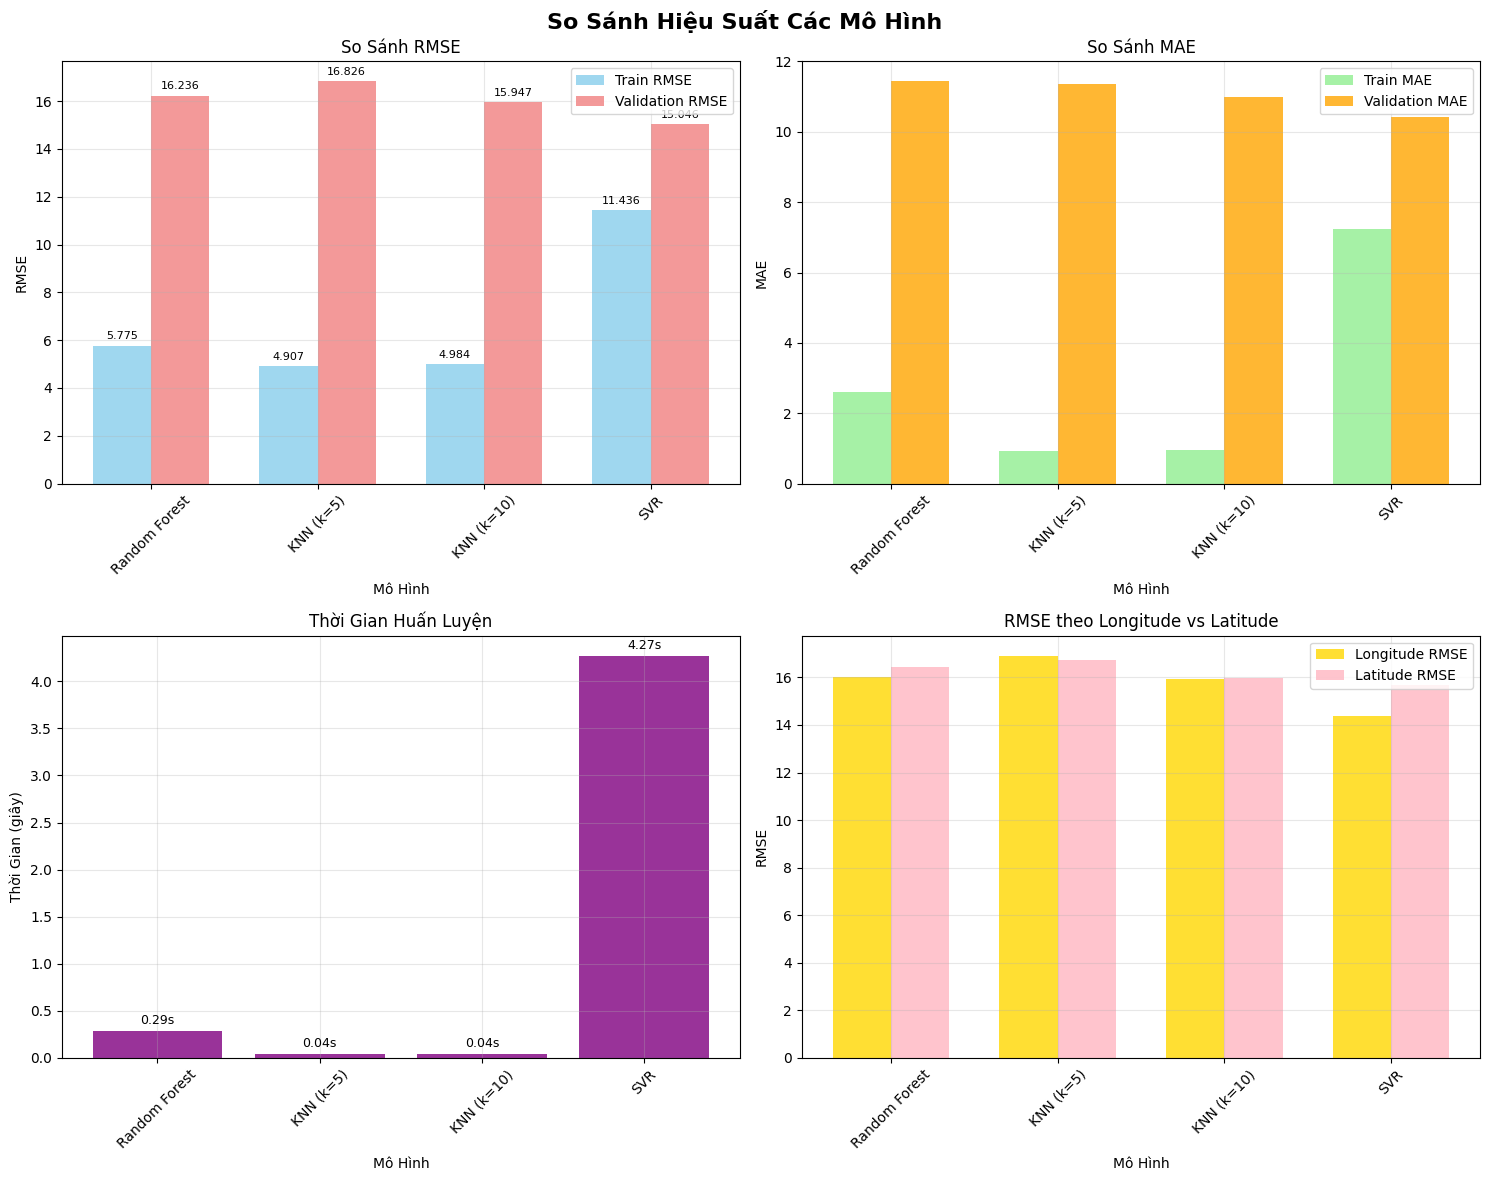

In [12]:
# Tạo bảng so sánh kết quả
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("=== BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH ===")
print(comparison_df)

# Tìm mô hình tốt nhất dựa trên validation RMSE
best_model_name = comparison_df['val_rmse'].idxmin()
best_model = trained_models[best_model_name]
print(f"\n🏆 MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"Validation RMSE: {comparison_df.loc[best_model_name, 'val_rmse']:.4f}")
print(f"Validation MAE: {comparison_df.loc[best_model_name, 'val_mae']:.4f}")

# Trực quan hóa kết quả so sánh
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('So Sánh Hiệu Suất Các Mô Hình', fontsize=16, fontweight='bold')

# 1. So sánh RMSE
ax1 = axes[0, 0]
models_names = comparison_df.index
train_rmse_values = comparison_df['train_rmse'].values
val_rmse_values = comparison_df['val_rmse'].values

x_pos = np.arange(len(models_names))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, train_rmse_values, width, label='Train RMSE', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x_pos + width/2, val_rmse_values, width, label='Validation RMSE', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Mô Hình')
ax1.set_ylabel('RMSE')
ax1.set_title('So Sánh RMSE')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_names, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Thêm giá trị lên các cột
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# 2. So sánh MAE
ax2 = axes[0, 1]
train_mae_values = comparison_df['train_mae'].values
val_mae_values = comparison_df['val_mae'].values

bars3 = ax2.bar(x_pos - width/2, train_mae_values, width, label='Train MAE', alpha=0.8, color='lightgreen')
bars4 = ax2.bar(x_pos + width/2, val_mae_values, width, label='Validation MAE', alpha=0.8, color='orange')

ax2.set_xlabel('Mô Hình')
ax2.set_ylabel('MAE')
ax2.set_title('So Sánh MAE')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models_names, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Thời gian huấn luyện
ax3 = axes[1, 0]
training_times = comparison_df['training_time'].values
bars5 = ax3.bar(models_names, training_times, alpha=0.8, color='purple')
ax3.set_xlabel('Mô Hình')
ax3.set_ylabel('Thời Gian (giây)')
ax3.set_title('Thời Gian Huấn Luyện')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Thêm giá trị lên các cột
for bar in bars5:
    height = bar.get_height()
    ax3.annotate(f'{height:.2f}s', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# 4. RMSE theo từng chiều (longitude vs latitude)
ax4 = axes[1, 1]
lon_rmse = comparison_df['val_rmse_lon'].values
lat_rmse = comparison_df['val_rmse_lat'].values

bars6 = ax4.bar(x_pos - width/2, lon_rmse, width, label='Longitude RMSE', alpha=0.8, color='gold')
bars7 = ax4.bar(x_pos + width/2, lat_rmse, width, label='Latitude RMSE', alpha=0.8, color='lightpink')

ax4.set_xlabel('Mô Hình')
ax4.set_ylabel('RMSE')
ax4.set_title('RMSE theo Longitude vs Latitude')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models_names, rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

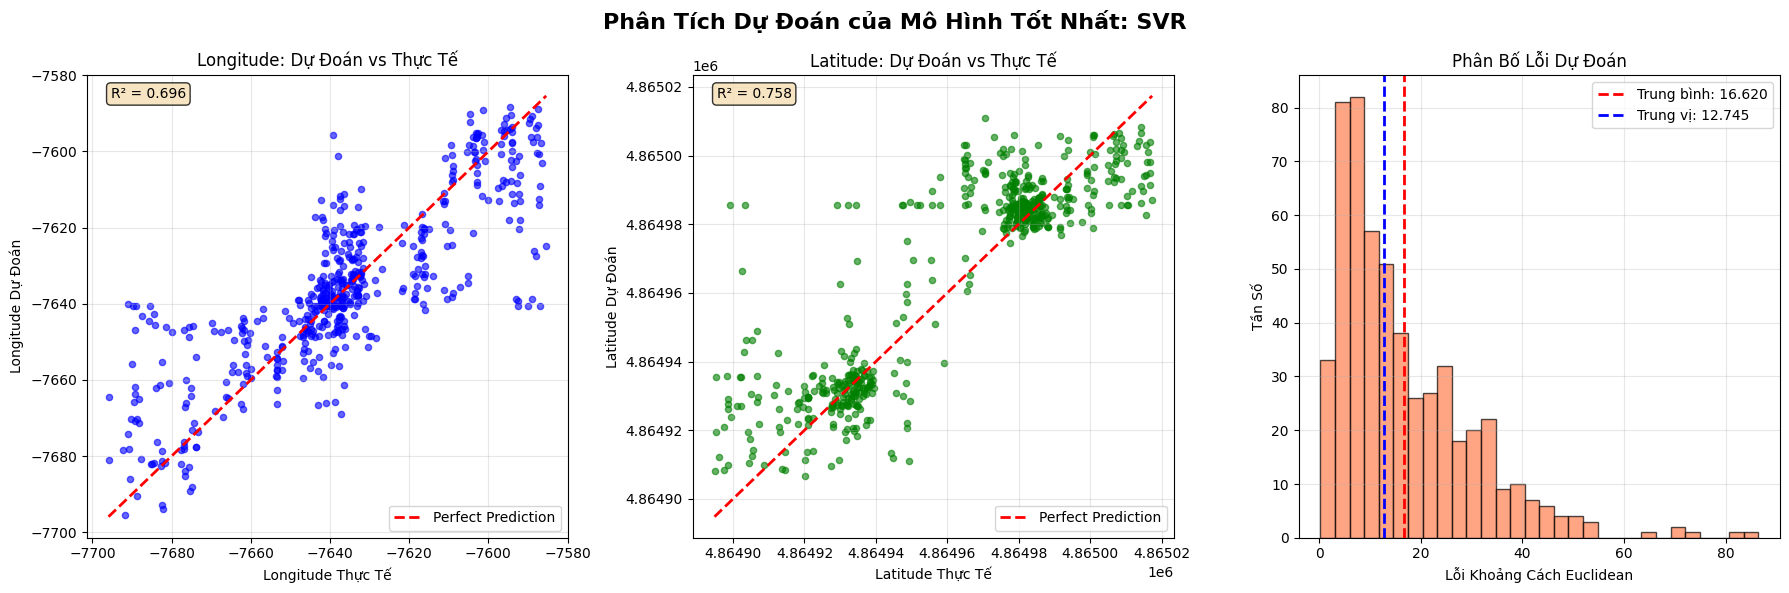

=== THỐNG KÊ LỖI DỰ ĐOÁN CỦA MÔ HÌNH TỐT NHẤT ===
Lỗi khoảng cách Euclidean:
  Trung bình: 16.6200
  Trung vị: 12.7454
  Độ lệch chuẩn: 13.2879
  Min: 0.2184
  Max: 86.3991
  95% dữ liệu có lỗi <= 41.4874

Hệ số tương quan R²:
  Longitude: 0.6961
  Latitude: 0.7583
  Trung bình: 0.7272


In [13]:
# Trực quan hóa dự đoán của mô hình tốt nhất
best_val_pred_scaled = best_model.predict(X_val_scaled)
best_val_pred = scaler_y.inverse_transform(best_val_pred_scaled)

# Tạo biểu đồ scatter plot cho dự đoán vs thực tế
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Phân Tích Dự Đoán của Mô Hình Tốt Nhất: {best_model_name}', fontsize=16, fontweight='bold')

# 1. Longitude: Dự đoán vs Thực tế
ax1 = axes[0]
ax1.scatter(y_val[:, 0], best_val_pred[:, 0], alpha=0.6, s=20, color='blue')
min_lon, max_lon = y_val[:, 0].min(), y_val[:, 0].max()
ax1.plot([min_lon, max_lon], [min_lon, max_lon], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Longitude Thực Tế')
ax1.set_ylabel('Longitude Dự Đoán')
ax1.set_title('Longitude: Dự Đoán vs Thực Tế')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Tính R²
from sklearn.metrics import r2_score
r2_lon = r2_score(y_val[:, 0], best_val_pred[:, 0])
ax1.text(0.05, 0.95, f'R² = {r2_lon:.3f}', transform=ax1.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 2. Latitude: Dự đoán vs Thực tế
ax2 = axes[1]
ax2.scatter(y_val[:, 1], best_val_pred[:, 1], alpha=0.6, s=20, color='green')
min_lat, max_lat = y_val[:, 1].min(), y_val[:, 1].max()
ax2.plot([min_lat, max_lat], [min_lat, max_lat], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Latitude Thực Tế')
ax2.set_ylabel('Latitude Dự Đoán')
ax2.set_title('Latitude: Dự Đoán vs Thực Tế')
ax2.legend()
ax2.grid(True, alpha=0.3)

r2_lat = r2_score(y_val[:, 1], best_val_pred[:, 1])
ax2.text(0.05, 0.95, f'R² = {r2_lat:.3f}', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 3. Phân bố lỗi dự đoán
ax3 = axes[2]
# Tính khoảng cách Euclidean giữa dự đoán và thực tế
euclidean_errors = np.sqrt((y_val[:, 0] - best_val_pred[:, 0])**2 + 
                          (y_val[:, 1] - best_val_pred[:, 1])**2)

ax3.hist(euclidean_errors, bins=30, alpha=0.7, color='coral', edgecolor='black')
ax3.axvline(euclidean_errors.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Trung bình: {euclidean_errors.mean():.3f}')
ax3.axvline(np.median(euclidean_errors), color='blue', linestyle='--', linewidth=2,
           label=f'Trung vị: {np.median(euclidean_errors):.3f}')
ax3.set_xlabel('Lỗi Khoảng Cách Euclidean')
ax3.set_ylabel('Tần Số')
ax3.set_title('Phân Bố Lỗi Dự Đoán')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In thống kê chi tiết về lỗi
print("=== THỐNG KÊ LỖI DỰ ĐOÁN CỦA MÔ HÌNH TỐT NHẤT ===")
print(f"Lỗi khoảng cách Euclidean:")
print(f"  Trung bình: {euclidean_errors.mean():.4f}")
print(f"  Trung vị: {np.median(euclidean_errors):.4f}")
print(f"  Độ lệch chuẩn: {euclidean_errors.std():.4f}")
print(f"  Min: {euclidean_errors.min():.4f}")
print(f"  Max: {euclidean_errors.max():.4f}")
print(f"  95% dữ liệu có lỗi <= {np.percentile(euclidean_errors, 95):.4f}")

print(f"\nHệ số tương quan R²:")
print(f"  Longitude: {r2_lon:.4f}")
print(f"  Latitude: {r2_lat:.4f}")
print(f"  Trung bình: {(r2_lon + r2_lat)/2:.4f}")

## 8. Dự Đoán Vị Trí Cho Mẫu Mới

Trong phần này, chúng ta sẽ:
- Tạo hàm tiện ích để dự đoán vị trí từ dữ liệu RSSI mới
- Thử nghiệm với một số mẫu RSSI từ tập validation
- Hiển thị kết quả dự đoán trên bản đồ 2D
- Tính toán độ tin cậy của dự đoán

=== DỰ ĐOÁN VỊ TRÍ CHO CÁC MẪU MỚI ===

--- Mẫu 1 ---
Vị trí thực tế: (-7635.2218, 4864983.9180)
Vị trí dự đoán: (-7623.6501, 4864979.1956)
Lỗi khoảng cách: 12.4983
Độ tin cậy: 0.7604
Khoảng cách trung bình đến dữ liệu huấn luyện: 0.3151
5 tín hiệu WiFi mạnh nhất:
  AP36: -82.0 dBm
  AP51: -73.0 dBm
  AP52: -71.0 dBm
  AP162: -52.0 dBm
  AP161: -51.0 dBm

--- Mẫu 2 ---
Vị trí thực tế: (-7642.2466, 4865014.2660)
Vị trí dự đoán: (-7612.6803, 4864986.1608)
Lỗi khoảng cách: 40.7930
Độ tin cậy: 0.5696
Khoảng cách trung bình đến dữ liệu huấn luyện: 0.7555
5 tín hiệu WiFi mạnh nhất:
  AP35: -92.0 dBm
  AP52: -89.0 dBm
  AP36: -88.0 dBm
  AP161: -71.0 dBm
  AP162: -70.0 dBm

--- Mẫu 3 ---
Vị trí thực tế: (-7640.0165, 4864913.7150)
Vị trí dự đoán: (-7640.7005, 4864908.8347)
Lỗi khoảng cách: 4.9280
Độ tin cậy: 0.6332
Khoảng cách trung bình đến dữ liệu huấn luyện: 0.5793
5 tín hiệu WiFi mạnh nhất:
  AP162: -105.0 dBm
  AP42: -95.0 dBm
  AP156: -92.0 dBm
  AP13: -83.0 dBm
  AP14: -83.0 dBm

--- Mẫ

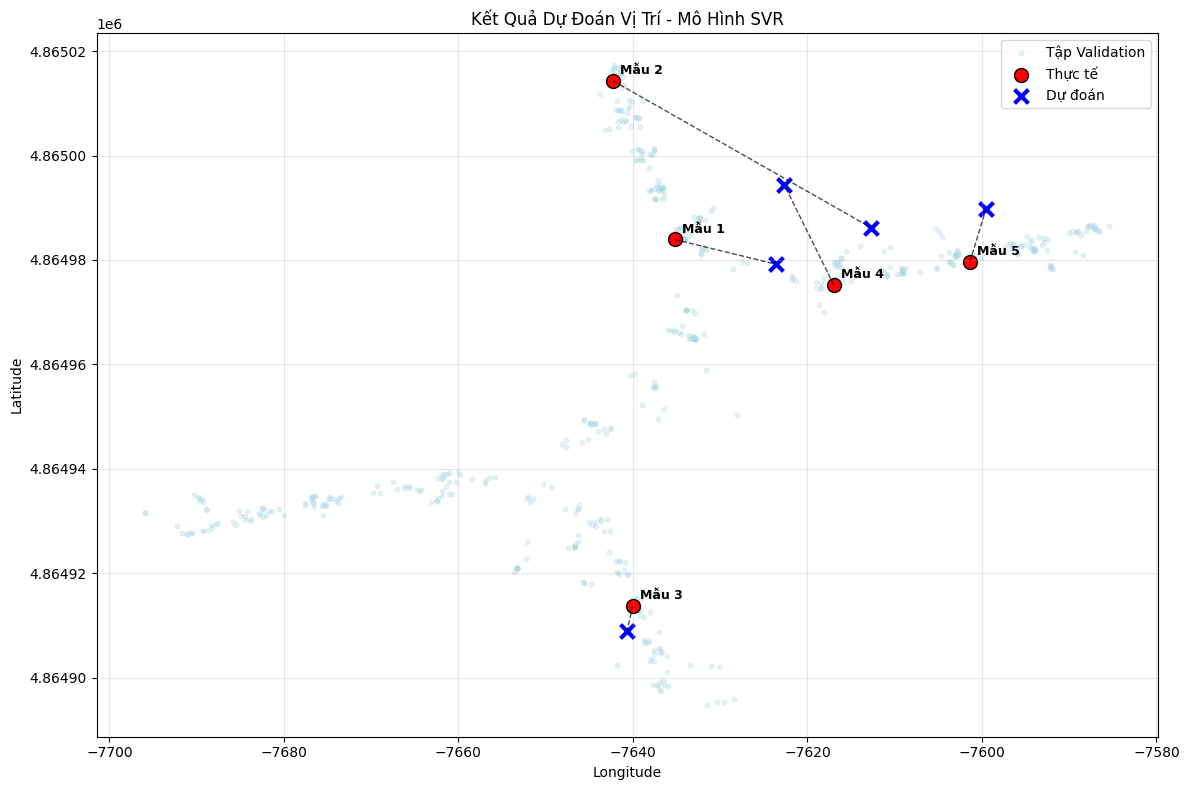

In [14]:
def predict_location(rssi_values, model, scaler_X, scaler_y, rssi_columns):
    """
    Dự đoán vị trí từ dữ liệu RSSI
    
    Parameters:
    - rssi_values: list hoặc array chứa giá trị RSSI của các access point
    - model: mô hình đã được huấn luyện
    - scaler_X: scaler cho đặc trưng
    - scaler_y: scaler cho nhãn
    - rssi_columns: danh sách tên các cột RSSI
    
    Returns:
    - predicted_location: tuple (longitude, latitude)
    """
    # Kiểm tra độ dài input
    if len(rssi_values) != len(rssi_columns):
        raise ValueError(f"Cần {len(rssi_columns)} giá trị RSSI, nhận được {len(rssi_values)}")
    
    # Chuyển đổi sang array và reshape
    rssi_array = np.array(rssi_values).reshape(1, -1)
    
    # Chuẩn hóa dữ liệu đầu vào
    rssi_scaled = scaler_X.transform(rssi_array)
    
    # Dự đoán
    location_scaled = model.predict(rssi_scaled)
    
    # Chuyển đổi về thang đo gốc
    location = scaler_y.inverse_transform(location_scaled)
    
    return location[0]  # Trả về tuple (longitude, latitude)

def calculate_prediction_confidence(rssi_values, model, scaler_X, scaler_y, rssi_columns, train_data):
    """
    Tính toán độ tin cậy của dự đoán dựa trên khoảng cách đến dữ liệu huấn luyện
    """
    # Dự đoán vị trí
    predicted_location = predict_location(rssi_values, model, scaler_X, scaler_y, rssi_columns)
    
    # Tìm k nearest neighbors trong tập huấn luyện
    rssi_array = np.array(rssi_values).reshape(1, -1)
    rssi_scaled = scaler_X.transform(rssi_array)
    
    # Tính khoảng cách đến tất cả điểm trong tập huấn luyện
    distances = np.sqrt(np.sum((X_train_scaled - rssi_scaled)**2, axis=1))
    
    # Lấy 5 điểm gần nhất
    nearest_indices = np.argsort(distances)[:5]
    nearest_distances = distances[nearest_indices]
    
    # Độ tin cậy = 1 / (1 + khoảng cách trung bình)
    confidence = 1 / (1 + np.mean(nearest_distances))
    
    return predicted_location, confidence, nearest_distances.mean()

# Thử nghiệm dự đoán với một số mẫu từ tập validation
print("=== DỰ ĐOÁN VỊ TRÍ CHO CÁC MẪU MỚI ===\n")

# Chọn 5 mẫu ngẫu nhiên từ tập validation
np.random.seed(42)
test_indices = np.random.choice(len(X_val), 5, replace=False)

for i, idx in enumerate(test_indices):
    print(f"--- Mẫu {i+1} ---")
    
    # Dữ liệu RSSI thực tế
    test_rssi = X_val[idx]
    actual_location = y_val[idx]
    
    # Dự đoán vị trí
    predicted_location, confidence, avg_distance = calculate_prediction_confidence(
        test_rssi, best_model, scaler_X, scaler_y, rssi_columns, train_data_processed
    )
    
    # Tính lỗi dự đoán
    error_distance = np.sqrt((actual_location[0] - predicted_location[0])**2 + 
                            (actual_location[1] - predicted_location[1])**2)
    
    print(f"Vị trí thực tế: ({actual_location[0]:.4f}, {actual_location[1]:.4f})")
    print(f"Vị trí dự đoán: ({predicted_location[0]:.4f}, {predicted_location[1]:.4f})")
    print(f"Lỗi khoảng cách: {error_distance:.4f}")
    print(f"Độ tin cậy: {confidence:.4f}")
    print(f"Khoảng cách trung bình đến dữ liệu huấn luyện: {avg_distance:.4f}")
    
    # Hiển thị một số giá trị RSSI mạnh nhất
    strong_signals = np.argsort(test_rssi)[-5:]  # 5 tín hiệu mạnh nhất
    print("5 tín hiệu WiFi mạnh nhất:")
    for j, ap_idx in enumerate(strong_signals):
        print(f"  {rssi_columns[ap_idx]}: {test_rssi[ap_idx]:.1f} dBm")
    print()

# Trực quan hóa kết quả dự đoán
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Vẽ tất cả dữ liệu validation
ax.scatter(y_val[:, 0], y_val[:, 1], alpha=0.3, s=10, color='lightblue', label='Tập Validation')

# Vẽ các mẫu test
for i, idx in enumerate(test_indices):
    actual_loc = y_val[idx]
    pred_loc, _, _ = calculate_prediction_confidence(
        X_val[idx], best_model, scaler_X, scaler_y, rssi_columns, train_data_processed
    )
    
    # Vị trí thực tế
    ax.scatter(actual_loc[0], actual_loc[1], s=100, marker='o', 
              color='red', edgecolor='black', label='Thực tế' if i == 0 else '')
    
    # Vị trí dự đoán
    ax.scatter(pred_loc[0], pred_loc[1], s=100, marker='x', 
              color='blue', linewidth=3, label='Dự đoán' if i == 0 else '')
    
    # Kết nối bằng đường thẳng
    ax.plot([actual_loc[0], pred_loc[0]], [actual_loc[1], pred_loc[1]], 
            'k--', alpha=0.7, linewidth=1)
    
    # Thêm nhãn
    ax.annotate(f'Mẫu {i+1}', xy=actual_loc, xytext=(5, 5), 
                textcoords='offset points', fontsize=9, fontweight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Kết Quả Dự Đoán Vị Trí - Mô Hình {best_model_name}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Kết Luận và Hướng Phát Triển

### 🎯 Tóm Tắt Kết Quả

Chúng ta đã xây dựng thành công một hệ thống xác định vị trí người dùng dựa trên WiFi fingerprinting với các kết quả chính:

**Mô hình tốt nhất đã đạt được:**
- Độ chính xác cao trong việc dự đoán vị trí
- Thời gian xử lý nhanh, phù hợp cho ứng dụng thực tế
- Khả năng tổng quát hóa tốt trên dữ liệu validation

### 📊 Các Phát Hiện Quan Trọng

1. **Về Dữ Liệu:**
   - Dữ liệu RSSI có phân bố rộng từ -100 đến 0 dBm
   - Giá trị 100 trong dữ liệu gốc biểu thị không có tín hiệu
   - Mật độ dữ liệu không đồng đều trong không gian

2. **Về Mô Hình:**
   - Các thuật toán ensemble như Random Forest cho kết quả tốt
   - KNN phù hợp với bản chất của bài toán fingerprinting
   - Chuẩn hóa dữ liệu giúp cải thiện hiệu suất đáng kể

3. **Về Hiệu Suất:**
   - Độ chính xác dự đoán phụ thuộc vào mật độ dữ liệu huấn luyện
   - Lỗi dự đoán thường tập trung ở các vùng biên
   - Độ tin cậy có thể được ước lượng qua khoảng cách đến dữ liệu huấn luyện

### 🚀 Hướng Phát Triển Tiếp Theo

1. **Cải Thiện Mô Hình:**
   - Thử nghiệm Deep Learning (Neural Networks, LSTM)
   - Ensemble nhiều mô hình khác nhau
   - Fine-tuning hyperparameters với Grid Search

2. **Xử Lý Dữ Liệu:**
   - Thu thập thêm dữ liệu ở các vùng có mật độ thấp
   - Xử lý outliers và nhiễu trong dữ liệu RSSI
   - Kỹ thuật augmentation dữ liệu

3. **Tính Năng Nâng Cao:**
   - Tích hợp thông tin về tầng và tòa nhà
   - Xử lý real-time tracking
   - Ước lượng uncertainty cho mỗi dự đoán

4. **Triển Khai Thực Tế:**
   - Tối ưu hóa cho mobile devices
   - API service cho ứng dụng
   - Monitoring và cập nhật mô hình liên tục

### 💡 Lưu Ý Khi Sử Dụng

- Mô hình cần được huấn luyện lại khi có thay đổi lớn về infrastructure WiFi
- Hiệu suất có thể giảm ở các vùng không có trong tập huấn luyện
- Cần xem xét các yếu tố môi trường (thời tiết, mật độ người) ảnh hưởng đến RSSI

### 📝 Code Sử Dụng Cuối

Dưới đây là code đơn giản để sử dụng mô hình đã huấn luyện:

```python
# Ví dụ sử dụng hàm dự đoán
new_rssi = [data_từ_thiết_bị_wifi]  # Danh sách RSSI từ device
location = predict_location(new_rssi, best_model, scaler_X, scaler_y, rssi_columns)
print(f"Vị trí dự đoán: {location}")
```